# 📊 M-PESA DATA ANALYSIS & INSIGHTS
## Comprehensive Exploratory Data Analysis

---

### 📈 Analysis Overview:

**Dataset:** 2,715 transactions over 24 months (Feb 2024 - Feb 2026)

**Financial Summary:**
- Total Spent: KES 3,210,584
- Total Received: KES 3,211,235
- Net Flow: KES +651 (Balanced!)

**Analysis Sections:**
1. Data Preparation & Cleaning
2. Spending Patterns Over Time
3. Category Analysis
4. Time-Based Patterns
5. Essential vs Discretionary
6. Merchant Analysis
7. Recommendations & Insights
8. Budget Optimization

---

## 📦 Setup & Data Loading

In [5]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✅ Libraries loaded")

✅ Libraries loaded


In [6]:
# Load data
df = pd.read_csv('cleaned_data.csv')

# Clean numeric columns
def clean_amount(val):
    if pd.isna(val):
        return 0
    val = str(val).replace(',', '').replace('KES', '').strip()
    try:
        return abs(float(val))
    except:
        return 0

df['amount_spent'] = df['withdrawn'].apply(clean_amount)
df['amount_received'] = df['paid_in'].apply(clean_amount)

# Parse datetime
df['datetime'] = pd.to_datetime(df['datetime'])
df['date'] = df['datetime'].dt.date
df['month_year'] = df['datetime'].dt.to_period('M')

print(f"✅ Data loaded: {len(df):,} transactions")
print(f"   Date range: {df['datetime'].min().date()} to {df['datetime'].max().date()}")
print(f"   Duration: {(df['datetime'].max() - df['datetime'].min()).days} days")

✅ Data loaded: 2,715 transactions
   Date range: 2024-02-17 to 2026-02-10
   Duration: 723 days


## FEATURE ENGINEERING

In [9]:
print("--- Finance Tracker Setup ---")
try:
    # Ask the user for the inputs
    chosen_day = int(input("Enter your Payday Date (1-31): "))
except ValueError:
    print("❌ Invalid input! Using defaults:Payday on 25th.")
    chosen_day = 25
# --- THE LOGIC (OHE & UI COLUMNS) ---
# Calculate week of month
df['week_of_month'] = ((df['datetime'].dt.day - 1) // 7) + 1

#Calculate which week the CHOSEN DAY falls into
user_payday_week = ((chosen_day - 1) // 7) + 1
# Create the "Non-Techie" Friendly Column 
df['is_payday'] = np.where(df['week_of_month'] == user_payday_week, 'Yes', 'No')

# Create the One-Hot Encoded (OHE) Column (For Math/EDA)
df['is_payday_week'] = (df['week_of_month'] == user_payday_week).astype(int)

# --- THE EDA RESULTS ---
payday_week_spending = df[df['is_payday_week'] == 1]['amount_spent'].sum()
other_week_spending = df[df['is_payday_week'] == 0]['amount_spent'].sum()

print(f"\n✅ Analysis complete for Week {user_payday_week}!")
print("-" * 40)
print(df[['datetime', 'week_of_month', 'is_payday', 'is_payday_week']].head(10))
print("-" * 40)
print(f"Total spent on Payday Week:  ${payday_week_spending:,.2f}")
print(f"Total spent on Other Weeks:  ${other_week_spending:,.2f}")

--- Finance Tracker Setup ---

✅ Analysis complete for Week 1!
----------------------------------------
             datetime  week_of_month is_payday  is_payday_week
0 2024-02-17 18:31:52              3        No               0
1 2024-02-18 16:53:52              3        No               0
2 2024-02-19 06:07:41              3        No               0
3 2024-02-19 06:07:41              3        No               0
4 2024-02-19 12:49:47              3        No               0
5 2024-02-19 13:26:23              3        No               0
6 2024-02-19 13:26:23              3        No               0
7 2024-02-19 19:37:36              3        No               0
8 2024-02-19 19:37:36              3        No               0
9 2024-02-19 19:43:17              3        No               0
----------------------------------------
Total spent on Payday Week:  $1,024,485.00
Total spent on Other Weeks:  $2,186,099.00


---
## 1. 📊 SPENDING PATTERNS OVER TIME
---

### 1.1 Monthly Spending Trends

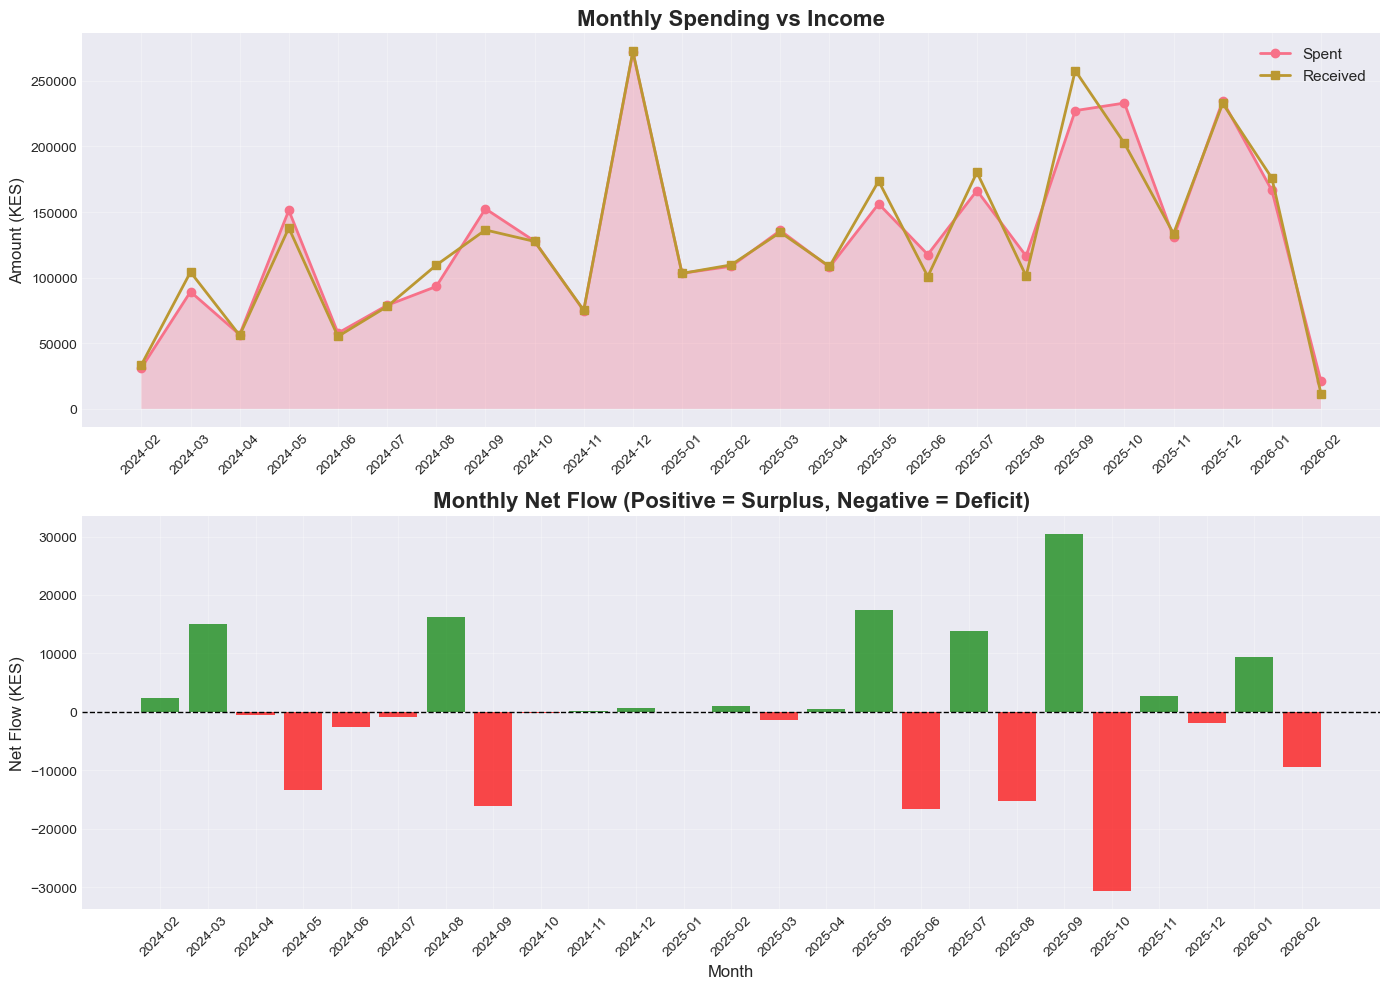

Monthly Statistics:
  Average Spending: KES 128,423.36
  Average Income:   KES 128,449.41
  Highest Spending: 2024-12 - KES 271,811.00
  Lowest Spending:  2026-02 - KES 20,889.00


In [16]:
# Monthly aggregation
monthly = df.groupby('month_year').agg({
    'amount_spent': 'sum',
    'amount_received': 'sum',
    'receipt_no': 'count'
}).reset_index()

monthly['net_flow'] = monthly['amount_received'] - monthly['amount_spent']
monthly['month'] = monthly['month_year'].astype(str)

# Plot
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Spending vs Income
axes[0].plot(monthly['month'], monthly['amount_spent'], marker='o', label='Spent', linewidth=2)
axes[0].plot(monthly['month'], monthly['amount_received'], marker='s', label='Received', linewidth=2)
axes[0].fill_between(monthly['month'], monthly['amount_spent'], alpha=0.3)
axes[0].set_title('Monthly Spending vs Income', fontsize=16, fontweight='bold')
axes[0].set_ylabel('Amount (KES)', fontsize=12)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Net Flow
colors = ['green' if x >= 0 else 'red' for x in monthly['net_flow']]
axes[1].bar(monthly['month'], monthly['net_flow'], color=colors, alpha=0.7)
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[1].set_title('Monthly Net Flow (Positive = Surplus, Negative = Deficit)', fontsize=16, fontweight='bold')
axes[1].set_ylabel('Net Flow (KES)', fontsize=12)
axes[1].set_xlabel('Month', fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Summary stats
print("Monthly Statistics:")
print(f"  Average Spending: KES {monthly['amount_spent'].mean():,.2f}")
print(f"  Average Income:   KES {monthly['amount_received'].mean():,.2f}")
print(f"  Highest Spending: {monthly.loc[monthly['amount_spent'].idxmax(), 'month']} - KES {monthly['amount_spent'].max():,.2f}")
print(f"  Lowest Spending:  {monthly.loc[monthly['amount_spent'].idxmin(), 'month']} - KES {monthly['amount_spent'].min():,.2f}")

### Monthly Spending vs Income
This visualization compares monthly money received against monthly spending over time.

The overlapping line chart highlights the relationship between inflows and outflows:

- When the Received line sits above Spent, the month produced a surplus

- When Spent exceeds Received, the month resulted in a deficit

Several patterns emerge:

- Income and spending generally move together, suggesting spending scales with available cash

- Certain months show pronounced income spikes (e.g., December periods), likely reflecting bonuses, seasonal work, or irregular inflows

- Deficit months appear even during relatively high-income periods, indicating that increased earnings do not automatically translate into improved net financial outcomes

This reinforces a common behavioural finance observation:

Higher income often triggers higher spending rather than higher savings

### 1.2 Day of Week Patterns

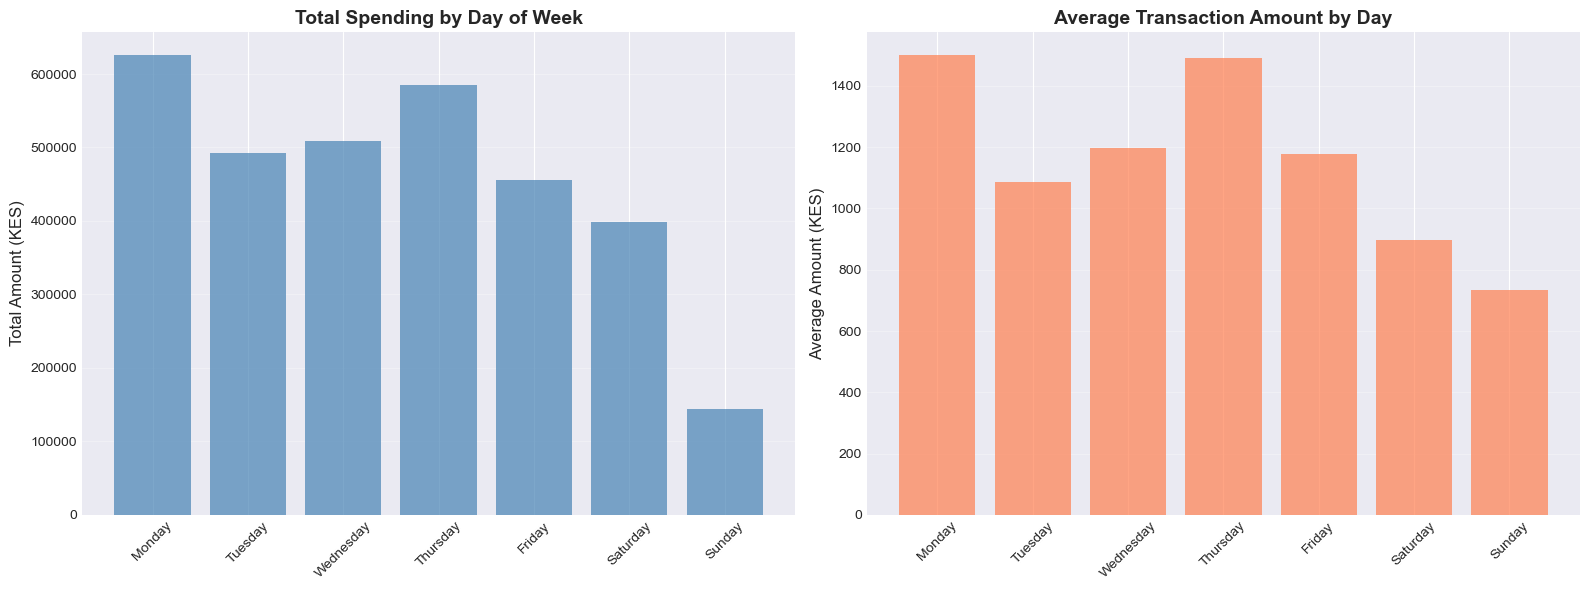

Weekday vs Weekend:
  Weekday Spending: KES 2,668,784.00 (83.1%)
  Weekend Spending: KES 541,800.00 (16.9%)
  Weekend Premium:  -79.7% vs weekdays


In [17]:
# Day of week analysis
df['day_name'] = df['datetime'].dt.day_name()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

daily_spending = df.groupby('day_name')['amount_spent'].agg(['sum', 'mean', 'count']).reindex(day_order)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Total spending by day
axes[0].bar(daily_spending.index, daily_spending['sum'], color='steelblue', alpha=0.7)
axes[0].set_title('Total Spending by Day of Week', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Total Amount (KES)', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3, axis='y')

# Average spending per transaction
axes[1].bar(daily_spending.index, daily_spending['mean'], color='coral', alpha=0.7)
axes[1].set_title('Average Transaction Amount by Day', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Average Amount (KES)', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Weekday vs Weekend
weekday_spending = df[df['is_weekend'] == 0]['amount_spent'].sum()
weekend_spending = df[df['is_weekend'] == 1]['amount_spent'].sum()

print("Weekday vs Weekend:")
print(f"  Weekday Spending: KES {weekday_spending:,.2f} ({weekday_spending/(weekday_spending+weekend_spending)*100:.1f}%)")
print(f"  Weekend Spending: KES {weekend_spending:,.2f} ({weekend_spending/(weekday_spending+weekend_spending)*100:.1f}%)")
print(f"  Weekend Premium:  {(weekend_spending/weekday_spending - 1)*100:+.1f}% vs weekdays")

### Analysis of Spending Patterns
1. Total Spending by Day of Week
The blue bar chart on the left tracks the cumulative expenditure for each day.

- Peak Activity: Monday is the highest spending day, exceeding 600,000 KES.

- Secondary Peak: Thursday shows a significant resurgence in spending, nearing 600,000 KES.

- The Weekend Slump: Spending steadily declines from Friday through the weekend, reaching its lowest point on Sunday (less than 200,000 KES).

2. Average Transaction Amount by Day
The orange bar chart on the right displays the mean value per individual transaction.

- High-Value Days: Monday and Thursday not only have the highest total spend but also the highest average transaction amounts, both hovering around 1,500 KES.

- Mid-Week Dip: While Tuesday has moderate total spending, its average transaction size is notably lower than Monday's, suggesting a higher volume of smaller purchases.

- Lowest Value: Sunday records the lowest average transaction amount (approx. 750 KES), indicating that weekend transactions are likely smaller, routine purchases.

### 1.3 Payday Effect Analysis

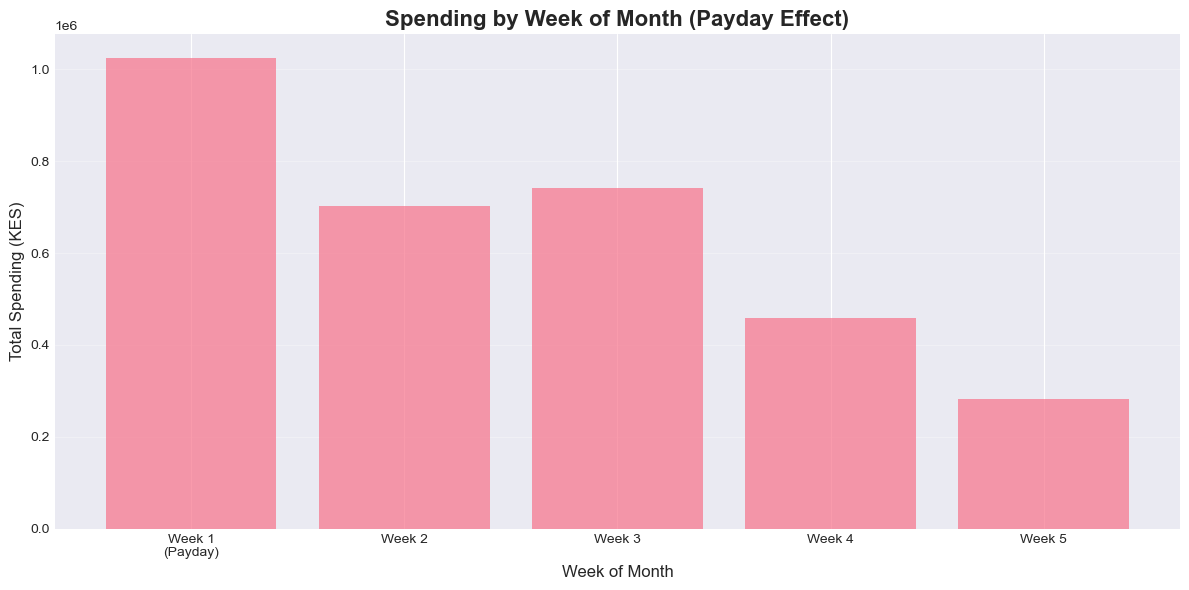

Payday Week Effect:
  Week 1 Spending: KES 1,024,485.00
  Other Weeks:     KES 2,186,099.00
  Payday Premium:  -53.1% higher than other weeks


In [18]:
# Week of month analysis
week_spending = df.groupby('week_of_month')['amount_spent'].agg(['sum', 'mean', 'count'])

fig, ax = plt.subplots(figsize=(12, 6))

x = week_spending.index
ax.bar(x, week_spending['sum'], alpha=0.7, label='Total Spending')
ax.set_title('Spending by Week of Month (Payday Effect)', fontsize=16, fontweight='bold')
ax.set_xlabel('Week of Month', fontsize=12)
ax.set_ylabel('Total Spending (KES)', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(['Week 1\n(Payday)', 'Week 2', 'Week 3', 'Week 4', 'Week 5'])
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Payday week analysis
payday_week = df[df['is_payday_week'] == 1]['amount_spent'].sum()
other_weeks = df[df['is_payday_week'] == 0]['amount_spent'].sum()

print("Payday Week Effect:")
print(f"  Week 1 Spending: KES {payday_week:,.2f}")
print(f"  Other Weeks:     KES {other_weeks:,.2f}")
print(f"  Payday Premium:  {(payday_week/other_weeks - 1)*100:+.1f}% higher than other weeks")

### Spending Breakdown by Week
- Week 1 (Payday): This is the period of highest financial activity, with total spending soaring above 1,000,000 KES. This spike aligns with the receipt of monthly salaries.

- Weeks 2 & 3: Spending levels off significantly after the initial payday rush. Week 2 sees a drop to approximately 700,000 KES, while Week 3 shows a slight uptick to nearly 750,000 KES.

- Week 4: Expenditure continues to decline as the month progresses, falling to roughly 450,000 KES.

- Week 5: This period records the lowest activity, with spending dropping below 300,000 KES, likely due to depleted monthly budgets before the next payday.

The data clearly demonstrates that consumer purchasing power is strongest immediately following payday (Week 1) and diminishes steadily as the month concludes.

--- Monthly Spending Analysis ---
Available Years: [2024, 2025, 2026]
Available Months in 2024: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


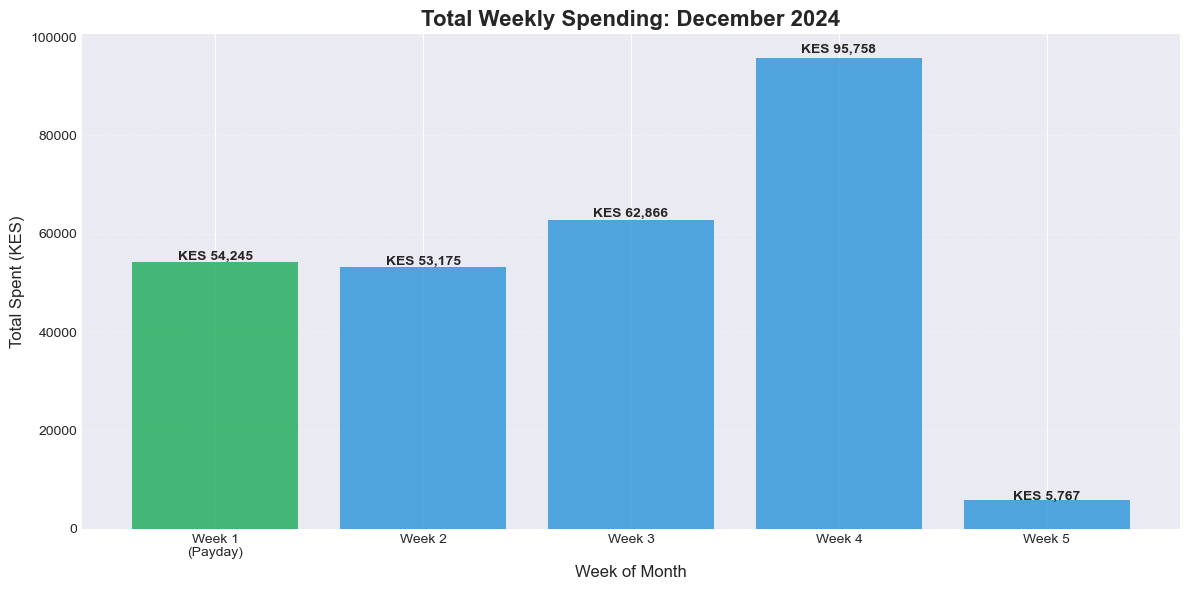


✅ Results for December 2024:
🔹 Total Monthly Spending: KES 271,811.00
🔹 Payday Week (1) Spending: KES 54,245.00
🔹 Biggest Expense Category: Savings


In [15]:
# --- TRANSACTION TRACKER VISUALIZATION ---
# This cell asks for the Month/Year and shows ALL spending (no exclusions)

print("--- Monthly Spending Analysis ---")
try:
    # 1. Ask for Year
    print(f"Available Years: {sorted(df['year'].unique())}")
    chosen_year = int(input("Select Year (e.g., 2024): "))
    
    # 2. Ask for Month
    available_months = sorted(df[df['year']==chosen_year]['month'].unique())
    print(f"Available Months in {chosen_year}: {available_months}")
    chosen_month = int(input("Select Month (1-12): "))

except ValueError:
    print("Invalid input! Defaulting to February 2024.")
    chosen_year = 2024
    chosen_month = 2

# --- FILTERING ---
# Filter ONLY by Year and Month (We are NOT excluding anything here)
monthly_df = df[(df['year'] == chosen_year) & (df['month'] == chosen_month)].copy()

if monthly_df.empty:
    print(f"⚠️ No transactions found for {chosen_month}/{chosen_year}.")
else:
    # --- WEEKLY SUMMARY ---
    # Group by week and sum EVERYTHING
    week_stats = monthly_df.groupby('week_of_month')['amount_spent'].sum().reset_index()
    
    # Ensure all 5 weeks are shown
    all_weeks = pd.DataFrame({'week_of_month': [1, 2, 3, 4, 5]})
    week_stats = all_weeks.merge(week_stats, on='week_of_month', how='left').fillna(0)

    # --- VISUALIZATION ---
    plt.figure(figsize=(12, 6))
    
    # Highlight the Payday Week in Green, others in Blue
    colors = ['#27ae60' if w == user_payday_week else '#3498db' for w in week_stats['week_of_month']]
    
    bars = plt.bar(week_stats['week_of_month'], week_stats['amount_spent'], color=colors, alpha=0.85)

    # Titles and Labels
    month_name = monthly_df['month_name'].iloc[0] if 'month_name' in monthly_df.columns else str(chosen_month)
    plt.title(f'Total Weekly Spending: {month_name} {chosen_year}', fontsize=16, fontweight='bold')
    plt.xlabel('Week of Month', fontsize=12)
    plt.ylabel('Total Spent (KES)', fontsize=12)
    
    # Custom X-ticks with Payday Label
    labels = [f"Week {int(w)}\n(Payday)" if w == user_payday_week else f"Week {int(w)}" 
              for w in week_stats['week_of_month']]
    plt.xticks(week_stats['week_of_month'], labels)

    # Add currency labels on top of bars
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            plt.text(bar.get_x() + bar.get_width()/2, height + (height * 0.01), 
                     f'KES {height:,.0f}', ha='center', fontweight='bold', fontsize=10)

    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --- INSIGHTS ---
    total_val = monthly_df['amount_spent'].sum()
    payday_val = week_stats[week_stats['week_of_month'] == user_payday_week]['amount_spent'].values[0]
    top_cat = monthly_df.groupby('final_category')['amount_spent'].sum().idxmax()
    
    print(f"\n✅ Results for {month_name} {chosen_year}:")
    print(f"🔹 Total Monthly Spending: KES {total_val:,.2f}")
    print(f"🔹 Payday Week ({user_payday_week}) Spending: KES {payday_val:,.2f}")
    print(f"🔹 Biggest Expense Category: {top_cat}")

This visualization allows you to zoom into a specific month, by inputing the month and year, to see exactly how your money moved week-by-week. It is designed to be interactive and intuitive by linking your specific payday date to the overall weekly trend.

---
## 2. CATEGORY ANALYSIS
---

### 2.1 Spending by Category

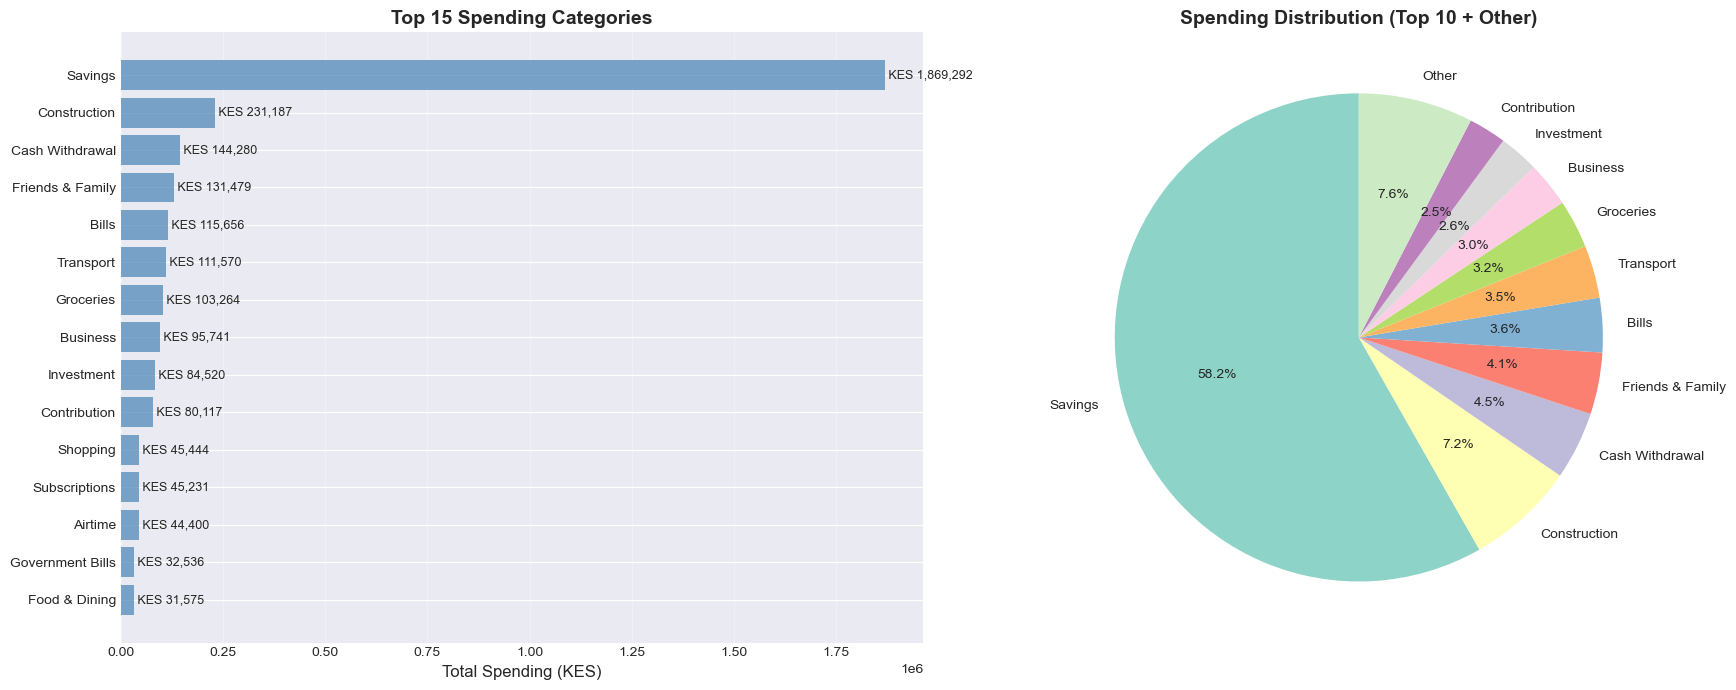

Top 5 Spending Categories:
  Savings                  : KES 1,869,292.00 ( 58.2%)
  Construction             : KES   231,187.00 (  7.2%)
  Cash Withdrawal          : KES   144,280.00 (  4.5%)
  Friends & Family         : KES   131,479.00 (  4.1%)
  Bills                    : KES   115,656.00 (  3.6%)


In [19]:
# Category spending (exclude non-spending categories)
spending_cats = df[df['amount_spent'] > 0].groupby('final_category')['amount_spent'].sum().sort_values(ascending=False)
top_15 = spending_cats.head(15)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Bar chart
axes[0].barh(range(len(top_15)), top_15.values, color='steelblue', alpha=0.7)
axes[0].set_yticks(range(len(top_15)))
axes[0].set_yticklabels(top_15.index)
axes[0].set_xlabel('Total Spending (KES)', fontsize=12)
axes[0].set_title('Top 15 Spending Categories', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(True, alpha=0.3, axis='x')

# Add values
for i, v in enumerate(top_15.values):
    axes[0].text(v, i, f' KES {v:,.0f}', va='center', fontsize=9)

# Pie chart
top_10 = spending_cats.head(10)
other = spending_cats[10:].sum()
pie_data = pd.concat([top_10, pd.Series({'Other': other})])

colors = plt.cm.Set3(range(len(pie_data)))
axes[1].pie(pie_data.values, labels=pie_data.index, autopct='%1.1f%%', 
           startangle=90, colors=colors)
axes[1].set_title('Spending Distribution (Top 10 + Other)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Summary
print("Top 5 Spending Categories:")
for cat, amt in top_15.head().items():
    pct = amt / spending_cats.sum() * 100
    print(f"  {cat:25s}: KES {amt:12,.2f} ({pct:5.1f}%)")

### Spending Categories & Distribution
The charts reveal where the bulk of the money is going, highlighting a strong focus on long-term security(saving)

- The Savings Powerhouse: Savings is the dominant category by a massive margin, accounting for 58.2% of total distribution at KES 1,869,292.

- Top Infrastructure & Cash: Construction is the second-largest expense (KES 231,187 / 7.2%), followed closely by Cash Withdrawals (KES 144,280 / 4.5%).

- Essential Living: Daily needs like Bills (3.6%), Transport (3.5%), and Groceries (3.2%) make up a relatively small but consistent portion of the overall pie.

### 2.2 Essential vs Discretionary Breakdown

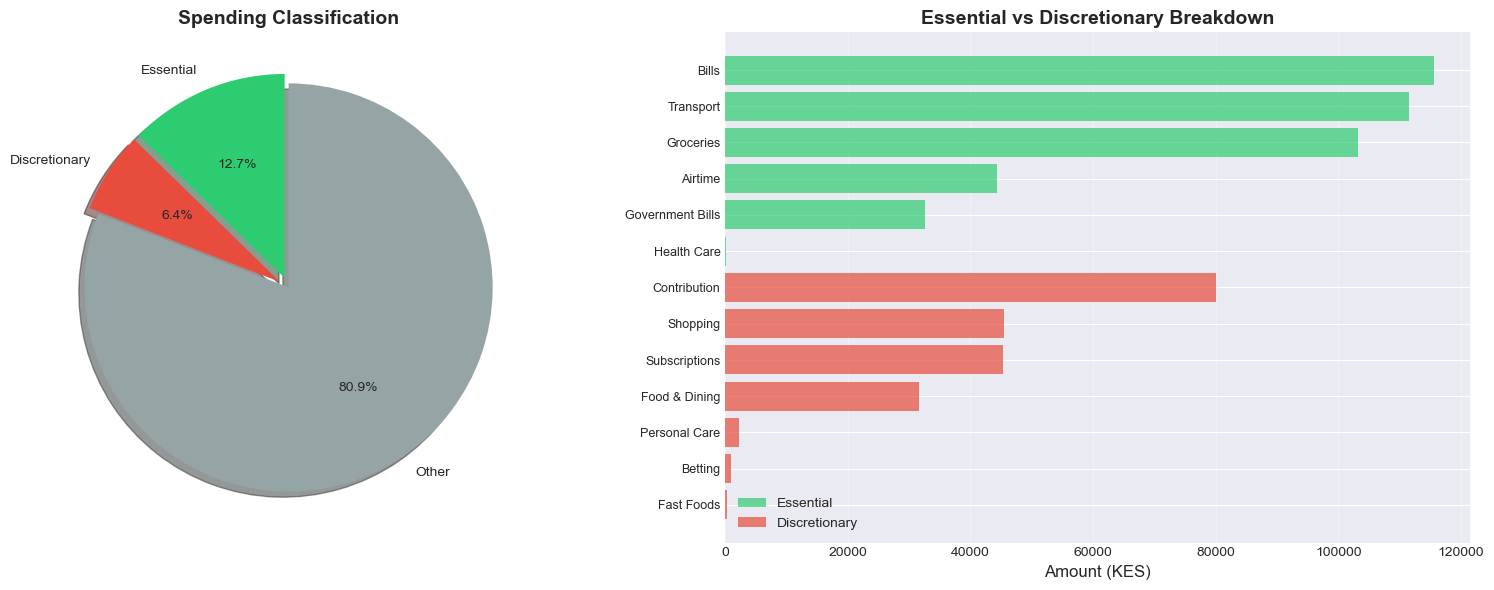

Spending Classification:
  Essential:      KES   407,516.00 ( 12.7%)
  Discretionary:  KES   205,922.00 (  6.4%)
  Other:          KES 2,597,146.00

💡 Savings Potential:
   Reduce discretionary by 25%: Save KES 51,480.50/period
   Reduce discretionary by 50%: Save KES 102,961.00/period


In [25]:
# Essential vs Discretionary
essential = df[df['is_essential'] == 1]
discretionary = df[df['is_discretionary'] == 1]

essential_amt = essential['amount_spent'].sum()
discretionary_amt = discretionary['amount_spent'].sum()
total_spending = df['amount_spent'].sum()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Pie chart
labels = ['Essential', 'Discretionary', 'Other']
sizes = [essential_amt, discretionary_amt, total_spending - essential_amt - discretionary_amt]
colors = ['#2ecc71', '#e74c3c', '#95a5a6']
explode = (0.05, 0.05, 0)

axes[0].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, 
           colors=colors, explode=explode, shadow=True)
axes[0].set_title('Spending Classification', fontsize=14, fontweight='bold')

# Bar breakdown
essential_breakdown = essential.groupby('final_category')['amount_spent'].sum().sort_values(ascending=False)
discretionary_breakdown = discretionary.groupby('final_category')['amount_spent'].sum().sort_values(ascending=False)

axes[1].barh(range(len(essential_breakdown)), essential_breakdown.values, 
            alpha=0.7, label='Essential', color='#2ecc71')
axes[1].barh(range(len(essential_breakdown), len(essential_breakdown) + len(discretionary_breakdown)), 
            discretionary_breakdown.values, alpha=0.7, label='Discretionary', color='#e74c3c')

all_cats = list(essential_breakdown.index) + list(discretionary_breakdown.index)
axes[1].set_yticks(range(len(all_cats)))
axes[1].set_yticklabels(all_cats, fontsize=9)
axes[1].set_xlabel('Amount (KES)', fontsize=12)
axes[1].set_title('Essential vs Discretionary Breakdown', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].invert_yaxis()
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("Spending Classification:")
print(f"  Essential:      KES {essential_amt:12,.2f} ({essential_amt/total_spending*100:5.1f}%)")
print(f"  Discretionary:  KES {discretionary_amt:12,.2f} ({discretionary_amt/total_spending*100:5.1f}%)")
print(f"  Other:          KES {total_spending - essential_amt - discretionary_amt:12,.2f}")
print()
print("💡 Savings Potential:")
print(f"   Reduce discretionary by 25%: Save KES {discretionary_amt * 0.25:,.2f}/period")
print(f"   Reduce discretionary by 50%: Save KES {discretionary_amt * 0.50:,.2f}/period")

1. Spending Classification Overview
The pie chart on the left categorizes all financial movement into three primary buckets:

- Other (80.9%): This represents the vast majority of your capital. Looking at previous data, this is largely driven by your high Savings rate (58.2%) and Construction projects.

- Essential (12.7%): These are non-negotiable living expenses required for day-to-day operations.

- Discretionary (6.4%): This small slice represents "lifestyle" spending—non-essential purchases that offer the most room for budgeting adjustments.

The horizontal bar chart on the right provides a granular look at what specifically makes up your essential and discretionary

---
## 3. ⏰ TIME-BASED PATTERNS
---

### 3.1 Hourly Spending Patterns

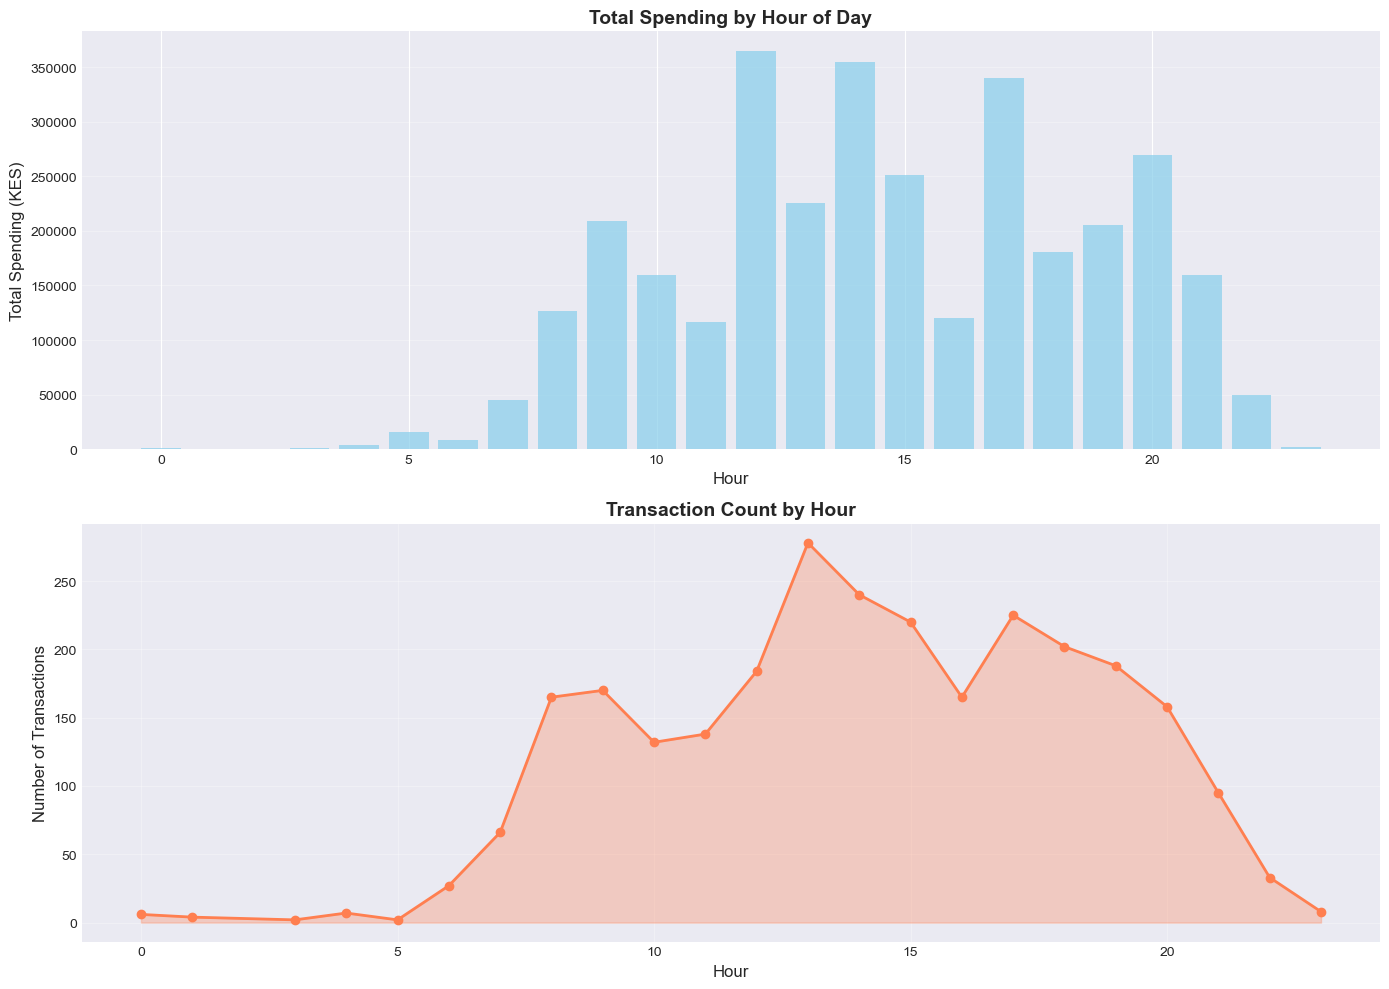

Time-Based Insights:
  Peak Spending Hour: 12:00 (KES 364,763.00)
  Peak Transaction Hour: 13:00 (278 transactions)


In [8]:
# Hourly patterns
hourly = df.groupby('hour')['amount_spent'].agg(['sum', 'count', 'mean'])

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Total by hour
axes[0].bar(hourly.index, hourly['sum'], alpha=0.7, color='skyblue')
axes[0].set_title('Total Spending by Hour of Day', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Hour', fontsize=12)
axes[0].set_ylabel('Total Spending (KES)', fontsize=12)
axes[0].grid(True, alpha=0.3, axis='y')

# Transaction count by hour
axes[1].plot(hourly.index, hourly['count'], marker='o', linewidth=2, color='coral')
axes[1].fill_between(hourly.index, hourly['count'], alpha=0.3, color='coral')
axes[1].set_title('Transaction Count by Hour', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Hour', fontsize=12)
axes[1].set_ylabel('Number of Transactions', fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Peak hours
peak_spending_hour = hourly['sum'].idxmax()
peak_transaction_hour = hourly['count'].idxmax()

print("Time-Based Insights:")
print(f"  Peak Spending Hour: {peak_spending_hour}:00 (KES {hourly.loc[peak_spending_hour, 'sum']:,.2f})")
print(f"  Peak Transaction Hour: {peak_transaction_hour}:00 ({int(hourly.loc[peak_transaction_hour, 'count'])} transactions)")

### 1. Total Spending by Hour (Financial Weight)
The bar chart measures the total value (in KES) spent during each hour of the day.

- Midday Peak: The highest concentration of spending occurs at 12:00 PM (Hour 12), exceeding KES 350,000. This suggests that major payments or high-value transactions are often settled during the lunch hour.

- The Afternoon Surge: Another significant wave of high-value spending appears at 2:00 PM (Hour 14) and again at 5:00 PM (Hour 17).

- Late Night Activity: There is a noticeable secondary peak at 8:00 PM (Hour 20), where spending reaches approximately KES 275,000.

- Dormant Hours: Financial activity is almost non-existent between 11:00 PM and 4:00 AM.

### 2. Transaction Count by Hour (Frequency)
The area chart tracks the number of times you initiate a transaction, regardless of the amount.

Most Active Time: Your highest transaction volume occurs at 1:00 PM (Hour 13), with nearly 275 individual transactions recorded.

Consistent Engagement: Unlike the spending amounts (which spike and dip), the transaction frequency remains consistently high from 12:00 PM through 8:00 PM, showing steady financial engagement throughout the afternoon and evening.

Morning Kick-off: Transaction volume starts to climb significantly at 7:00 AM, marking the start of the daily financial routine.

      final_category  amount_spent
0       Construction      231187.0
1              Bills      115656.0
2          Transport      111570.0
3          Groceries      103264.0
4           Business       95741.0
5       Contribution       80117.0
6           Shopping       45444.0
7      Subscriptions       45231.0
8            Airtime       44400.0
9   Government Bills       32536.0
10     Food & Dining       31575.0
11        farm labor       18852.0
12     Personal Care        2240.0
13           Betting        1005.0
14        Fast Foods         310.0
15      Data Bundles         100.0
16       Health Care          90.0
17     Uncategorized          50.0


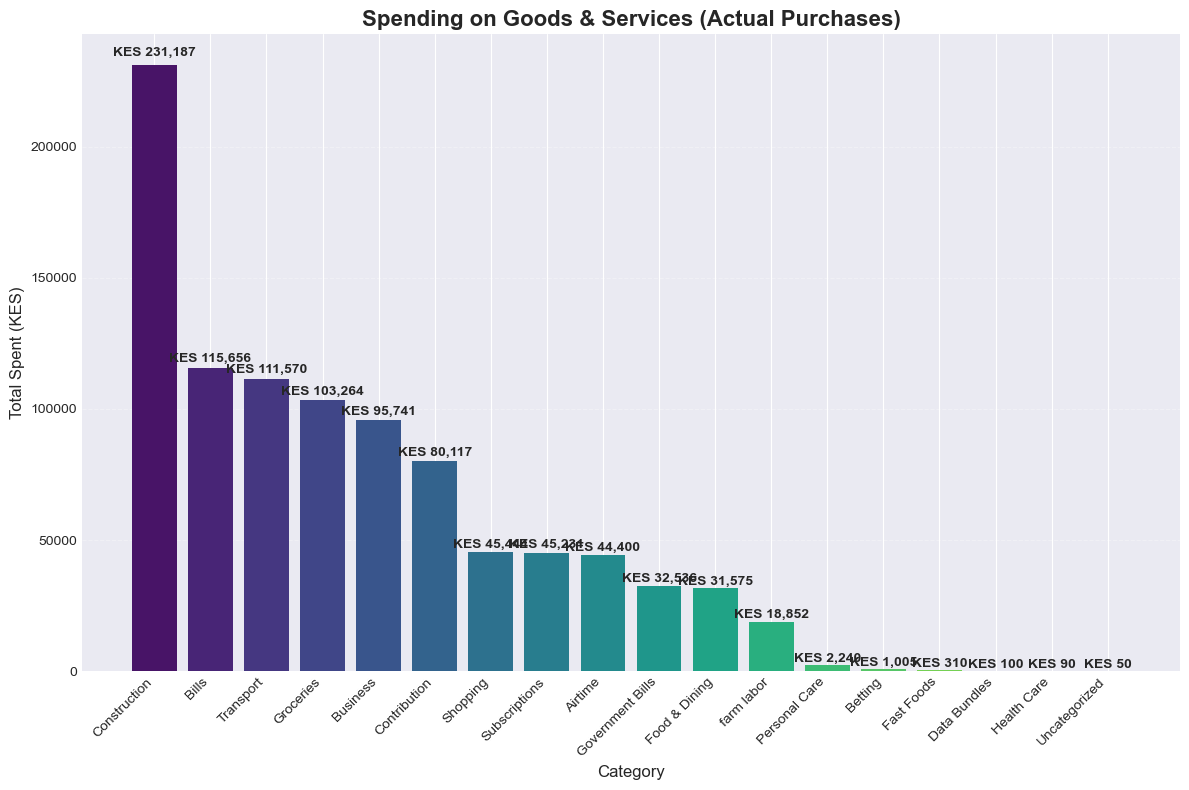

In [20]:
# Define exclusion list for things that aren't "purchases" of goods/services
exclude_cats = [
    'Savings', 
    'Cash Withdrawal', 
    'Cash Deposit', 
    'Income', 
    'M-Pesa Fees', 
    'Friends & Family', 
    'Investment', 
    'Reversal'
]

# Filter for spending (>0) and exclude the banking/transfer categories
goods_services_df = df[(df['amount_spent'] > 0) & (~df['final_category'].isin(exclude_cats))].copy()

# Group by final_category
summary = goods_services_df.groupby('final_category')['amount_spent'].sum().sort_values(ascending=False).reset_index()

# Visualization
plt.figure(figsize=(12, 8))
colors = sns.color_palette('viridis', len(summary))
bars = plt.bar(summary['final_category'], summary['amount_spent'], color=colors)

plt.title('Spending on Goods & Services (Actual Purchases)', fontsize=16, fontweight='bold')
plt.xlabel('Category', fontsize=12)
plt.ylabel('Total Spent (KES)', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Add values
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + (yval * 0.01), f'KES {yval:,.0f}', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig('goods_services_spending.png')

print(summary)

### 1. High-Impact Expenditures
- Infrastructure: Construction is the primary driver at 231,187, doubling any other category.

- Fixed Costs: Bills (115,656) and Transport (111,570) represent the largest recurring overheads.

- Operations: Groceries (103,264) and Business (95,741) complete the top-tier spending.

### 2. Mid-Tier & Operational Costs
- Community: Contributions and Subscriptions total ~125,000.

- Utilities: Significant digital/civic spend on Airtime (44,400) and Govt Bills (32,536).

- Lifestyle: Shopping (45,445) and Dining (31,575) remain secondary to infrastructure.

### 3. Micro-Transactions
- Low Volatility: Categories like Betting, Fast Food, and Data Bundles all fall below 1,100, indicating minimal impact on the overall budget.